In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import psi4
import PDFTer_with_reponse_unorthogonal as PDFT
import pickle

Check the cutoff.

In [7]:
def weight(D1,D2,Vpot,beta):
    C=6/4/(4*np.pi)**1.5
    
    points_func = Vpot.properties()[0]
    superfunc = Vpot.functional()
    
    density1 = 0.0
    density2 = 0.0
    
    xc_e = 0.0
    vv10_e = 0.0
    w1 = np.array([])
    w2 = np.array([])
    # First loop over the outer set of blocks
#     for l_block in range(Vpot.nblocks()):
    for l_block in range(Vpot.nblocks()):
        # Obtain general grid information
        l_grid = Vpot.get_block(l_block)
        l_w = np.array(l_grid.w())
        l_x = np.array(l_grid.x())
        l_y = np.array(l_grid.y())
        l_z = np.array(l_grid.z())
        l_npoints = l_w.shape[0]
        
        points_func.compute_points(l_grid)
        l_lpos = np.array(l_grid.functions_local_to_global())

        # Compute phi!
        l_phi = np.array(points_func.basis_values()["PHI"])[:l_npoints, :l_lpos.shape[0]]
        l_phi_x = np.array(points_func.basis_values()["PHI_X"])[:l_npoints, :l_lpos.shape[0]]
        l_phi_y = np.array(points_func.basis_values()["PHI_Y"])[:l_npoints, :l_lpos.shape[0]]
        l_phi_z = np.array(points_func.basis_values()["PHI_Z"])[:l_npoints, :l_lpos.shape[0]]
        # Build a local slice of D
        lD1 = D1[(l_lpos[:, None], l_lpos)]
        
        # Copmute block-rho and block-gamma
        rho1 = 2.0 * np.einsum('pm,mn,pn->p', l_phi, lD1, l_phi, optimize=True)
        # 2.0 for Px D P + P D Px, 2.0 for non-spin Density
        rho_x1 = 4.0 * np.einsum('pm,mn,pn->p', l_phi, lD1, l_phi_x, optimize=True)
        rho_y1 = 4.0 * np.einsum('pm,mn,pn->p', l_phi, lD1, l_phi_y, optimize=True)
        rho_z1 = 4.0 * np.einsum('pm,mn,pn->p', l_phi, lD1, l_phi_z, optimize=True)
        gamma1 = rho_x1 ** 2 + rho_y1 ** 2 + rho_z1 ** 2
        
        # The integral cutoff.
        l_local_w_homo = gamma1**0.5 < 2 * beta * ((9*np.pi)**(-1.0/6.0))*(rho1**(7.0/6.0))
#         l_local_w_gamma = gamma1 > threshold_gamma
        l_local_w_rho = rho1 > 1e-34
        l_local_w = l_local_w_homo*l_local_w_rho
#         l_local_w = l_local_w_homo
        
        # Build a local slice of D
        lD2 = D2[(l_lpos[:, None], l_lpos)]

        # Copmute block-rho and block-gamma
        rho2 = 2.0 * np.einsum('pm,mn,pn->p', l_phi, lD2, l_phi, optimize=True)
        # 2.0 for Px D P + P D Px, 2.0 for non-spin Density
        rho_x2 = 4.0 * np.einsum('pm,mn,pn->p', l_phi, lD2, l_phi_x, optimize=True)
        rho_y2 = 4.0 * np.einsum('pm,mn,pn->p', l_phi, lD2, l_phi_y, optimize=True)
        rho_z2 = 4.0 * np.einsum('pm,mn,pn->p', l_phi, lD2, l_phi_z, optimize=True)
        gamma2 = rho_x2 ** 2 + rho_y2 ** 2 + rho_z2 ** 2

        # The integrate cutoff.
        r_local_w_homo = gamma2**0.5 < 2 * beta * ((9*np.pi)**(-1.0/6.0))*(rho2**(7.0/6.0))
#         r_local_w_gamma = gamma2 > threshold_gamma
        r_local_w_rho = rho2 > 1e-34
        r_local_w = r_local_w_homo*r_local_w_rho
#         r_local_w = r_local_w_homo
        
        density1 += np.sum(rho1*l_w)
        density2 += np.sum(rho2*l_w)
        
        w1 = np.append(w1, r_local_w + l_local_w*2)
        w2 = np.append(w2, r_local_w_homo + l_local_w_homo*2)
        x,y,z,_ = Vpot.get_np_xyzw()
        w1 = w1.astype('int')
        w2 = w2.astype('int')
    print(density1, density2)
    return x,y,z,w1

2.000000621500336 2.000000621500334


<IPython.core.display.Javascript object>


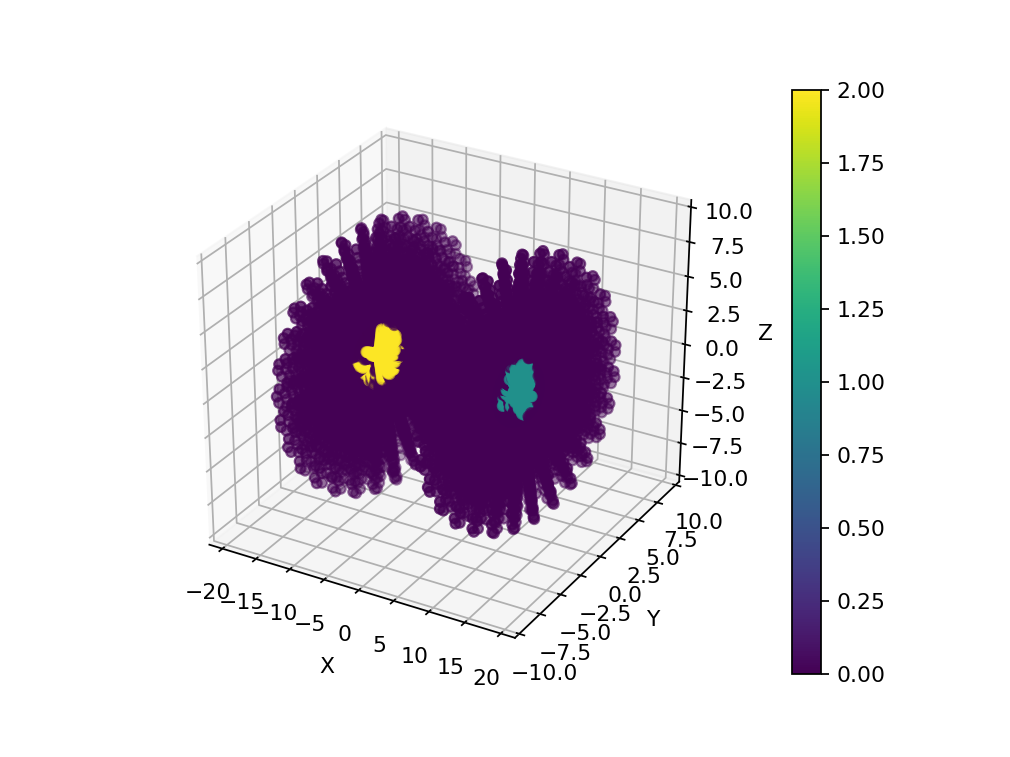

Text(0.5, 0, 'Z')

In [35]:
i = 20

Full_Molec =  psi4.geometry("""
nocom
noreorient
He %f 0.0 0.00
He -%f 0.0 0.00
symmetry c1
unit bohr
""" %(i/2.0,i/2.0))

Monomer_1 =  psi4.geometry("""
nocom
noreorient
@He %f 0.0 0.00
He -%f 0.0 0.00
symmetry c1
unit bohr
""" %(i/2.0,i/2.0))

Monomer_2 =  psi4.geometry("""
nocom
noreorient
He %f 0.0 0.00
@He -%f 0.0 0.00
unit bohr
symmetry c1
""" %(i/2.0,i/2.0))

optionsList = {
    'maxiter':         9000,
    'basis': 'cc-pvdz',
    'reference': 'RKS'
}
psi4.set_options(optionsList)

psi4.set_options(optionsList)
obj2_e, obj2_wfn = psi4.energy('pbe', molecule=Full_Molec, return_wfn=True)
psi4.core.clean
obj2_e1, obj2_wfn1 = psi4.energy('pbe', molecule=Monomer_1, return_wfn=True)
psi4.core.clean
obj2_e2, obj2_wfn2 = psi4.energy('pbe', molecule=Monomer_2, return_wfn=True)
psi4.core.clean

x,y,z,w1 = weight(obj2_wfn1.Da().np, obj2_wfn2.Da().np, obj2_wfn1.V_potential(), 6)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(x, y, z, c=w1)
plt.colorbar(p)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

Parameter $C=\frac{6e}{4(4\pi)^{3/2}m^{1/2}}$ in atomic units.

The integrate creteria $k_{local}/6=\frac{|\nabla \rho|}{6\rho}<k_{local}^{TF}=2(\frac{\rho}{9\pi})^{1/6}$

In [2]:
def compute_all96(D1,D2,Vpot,beta):
    C=-6.0/4.0/(4*np.pi)**1.5
    
    points_func = Vpot.properties()[0]
    superfunc = Vpot.functional()

    all96_e = 0.0
    n1 = 0.0
    
    # First loop over the outer set of blocks
    for l_block in range(Vpot.nblocks()):
#     for l_block in range(70,Vpot.nblocks()):
        # Obtain general grid information
        l_grid = Vpot.get_block(l_block)
        l_w = np.array(l_grid.w())
        l_x = np.array(l_grid.x())
        l_y = np.array(l_grid.y())
        l_z = np.array(l_grid.z())
        l_npoints = l_w.shape[0]
        
        points_func.compute_points(l_grid)
        l_lpos = np.array(l_grid.functions_local_to_global())

        # Compute phi!
        l_phi = np.array(points_func.basis_values()["PHI"])[:l_npoints, :l_lpos.shape[0]]
        l_phi_x = np.array(points_func.basis_values()["PHI_X"])[:l_npoints, :l_lpos.shape[0]]
        l_phi_y = np.array(points_func.basis_values()["PHI_Y"])[:l_npoints, :l_lpos.shape[0]]
        l_phi_z = np.array(points_func.basis_values()["PHI_Z"])[:l_npoints, :l_lpos.shape[0]]
        # Build a local slice of D
        lD1 = D1[(l_lpos[:, None], l_lpos)]
        
        # Copmute block-rho and block-gamma
        rho1 = 2.0 * np.einsum('pm,mn,pn->p', l_phi, lD1, l_phi, optimize=True)
        # 2.0 for Px D P + P D Px, 2.0 for non-spin Density
        rho_x1 = 4.0 * np.einsum('pm,mn,pn->p', l_phi, lD1, l_phi_x, optimize=True)
        rho_y1 = 4.0 * np.einsum('pm,mn,pn->p', l_phi, lD1, l_phi_y, optimize=True)
        rho_z1 = 4.0 * np.einsum('pm,mn,pn->p', l_phi, lD1, l_phi_z, optimize=True)
        gamma1 = rho_x1 ** 2 + rho_y1 ** 2 + rho_z1 ** 2
        
        # The integral cutoff.
        l_local_w_homo = gamma1**0.5 <= 2 * beta * ((9 * np.pi)**(-1.0/6.0))*(rho1**(7.0/6.0))
        l_local_w_rho = rho1 > 1e-34
        l_local_w = l_local_w_homo*l_local_w_rho

        if not np.any(l_local_w):
            continue
        
        l_integrant = np.zeros_like(rho1)
        
        n2 = 0.0
        
        # Loop over the inner set of blocks
        for r_block in range(Vpot.nblocks()):
            r_grid = Vpot.get_block(r_block)
            r_w = np.array(r_grid.w())
            r_x = np.array(r_grid.x())
            r_y = np.array(r_grid.y())
            r_z = np.array(r_grid.z())
            r_npoints = r_w.shape[0]
            
            points_func.compute_points(r_grid)
            r_lpos = np.array(r_grid.functions_local_to_global())
            
            # Compute phi!
            r_phi = np.array(points_func.basis_values()["PHI"])[:r_npoints, :r_lpos.shape[0]]
            r_phi_x = np.array(points_func.basis_values()["PHI_X"])[:r_npoints, :r_lpos.shape[0]]
            r_phi_y = np.array(points_func.basis_values()["PHI_Y"])[:r_npoints, :r_lpos.shape[0]]
            r_phi_z = np.array(points_func.basis_values()["PHI_Z"])[:r_npoints, :r_lpos.shape[0]]
            
            # Build a local slice of D
            lD2 = D2[(r_lpos[:, None], r_lpos)]

            # Copmute block-rho and block-gamma
            rho2 = 2.0 * np.einsum('pm,mn,pn->p', r_phi, lD2, r_phi, optimize=True)
            # 2.0 for Px D P + P D Px, 2.0 for non-spin Density
            rho_x2 = 4.0 * np.einsum('pm,mn,pn->p', r_phi, lD2, r_phi_x, optimize=True)
            rho_y2 = 4.0 * np.einsum('pm,mn,pn->p', r_phi, lD2, r_phi_y, optimize=True)
            rho_z2 = 4.0 * np.einsum('pm,mn,pn->p', r_phi, lD2, r_phi_z, optimize=True)
            gamma2 = rho_x2 ** 2 + rho_y2 ** 2 + rho_z2 ** 2
            
            # The integrate cutoff.
            r_local_w_homo = gamma2**0.5 <= 2 * beta * ((9 * np.pi)**(-1.0/6.0)) * (rho2**(7.0/6.0))
            r_local_w_rho = rho2 > 1e-34
            r_local_w = r_local_w_homo*r_local_w_rho
#             r_local_w = r_local_w_homo
            
            if not np.any(r_local_w):
                continue
    
            # Build the distnace matrix
            R2  = (l_x[:, None] - r_x) ** 2
            R2 += (l_y[:, None] - r_y) ** 2
            R2 += (l_z[:, None] - r_z) ** 2
            R2 += 1e-34
            R6inv = R2**-3
            
            # Integral
            r_integrant = np.sqrt(rho1[:, None] * rho2) / (np.sqrt(rho1[:, None]) + np.sqrt(rho2) + 1e-34) * R6inv 
            l_integrant += np.sum(r_integrant * r_local_w * r_w, axis=1)
            n2 += np.sum(rho2 * r_local_w * r_w)
            
#         print("DensityRight", n2)
        # The second integral
        all96_e += C*np.sum(l_integrant * l_local_w * l_w)
        n1 += np.sum(rho1 * l_local_w * l_w)
        assert abs(all96_e) < 1e3, "Unphysical all96 energy %f" %all96_e
    print("Electrons Used", n1, n2)
    print("ALL962", all96_e)
    return all96_e

Find the beta for the given basis set.

In [81]:
for beta in np.arange(5.5,5.9,0.1):
    bindingenergy = []
    bindinglength = []
    for i in range(30,90,15):
        Full_Molec =  psi4.geometry("""
        nocom
        noreorient
        Ar %f 0.0 0.00
        Ne -%f 0.0 0.00
        symmetry c1
        unit bohr
        """ %(i/2.0,i/2.0))

        Monomer_1 =  psi4.geometry("""
        nocom
        noreorient
        @Ar %f 0.0 0.00
        Ne -%f 0.0 0.00
        symmetry c1
        unit bohr
        """ %(i/2.0,i/2.0))

        Monomer_2 =  psi4.geometry("""
        nocom
        noreorient
        Ar %f 0.0 0.00
        @Ne -%f 0.0 0.00
        unit bohr
        symmetry c1
        """ %(i/2.0,i/2.0))
        
        optionsList = {
        'maxiter':         9000,
        'basis': 'cc-pvdz',
        'reference': 'RKS'
        }
        
        print("========================%i====================="%i)
        psi4.set_options(optionsList)
#         obj2_e, obj2_wfn = psi4.energy('pbe', molecule=Full_Molec, return_wfn=True)
#         psi4.core.clean
        obj2_e1, obj2_wfn1 = psi4.energy('pbe', molecule=Monomer_1, return_wfn=True)
        psi4.core.clean
        obj2_e2, obj2_wfn2 = psi4.energy('pbe', molecule=Monomer_2, return_wfn=True)
        psi4.core.clean
        
        energy = compute_all96(obj2_wfn1.Da().np, obj2_wfn2.Da().np, obj2_wfn1.V_potential(), beta)

        # From Hartree to Ry
        energy = energy*2
        bindingenergy.append(energy)
        bindinglength.append(i)
    x_arne = (np.array(bindinglength).astype(float))
    y_arne = np.array(bindingenergy)
    print(">>>>>>>>>>>>>>>>>>>>>>>>",beta, "<<<<<<<<<<<<<<<<<<<<<<<", np.polynomial.polynomial.polyfit(x_arne**-1,y_arne,[6], w=x_arne**6)[-1])

========================30=====================
Electrons Used 7.535582653023807 13.565068283025957
ALL962 2.4334512449876734e-08
========================45=====================
Electrons Used 7.535582708449849 13.565068609668952
ALL962 2.0866911185764143e-09
========================60=====================
Electrons Used 7.535582707068409 13.565068621817911
ALL962 3.683717959053708e-10
========================75=====================
Electrons Used 7.535582705561889 13.565068622712495
ALL962 9.62042778205661e-11
>>>>>>>>>>>>>>>>>>>>>>>> 5.5 <<<<<<<<<<<<<<<<<<<<<<< 34.6881513147141
========================30=====================
Electrons Used 7.732861350839228 13.637988383064583
ALL962 2.679959841208671e-08
========================45=====================
Electrons Used 7.732861402750525 13.637988848904973
ALL962 2.2938673835303626e-09
========================60=====================
Electrons Used 7.732861399602095 13.637988866929327
ALL962 4.046918037356478e-10
========================7

In [ ]:
for beta in np.arange(5.8,5.9,0.01):
    bindingenergy = []
    bindinglength = []
    for i in range(30,90,15):
        Full_Molec =  psi4.geometry("""
        nocom
        noreorient
        Ar %f 0.0 0.00
        Ne -%f 0.0 0.00
        symmetry c1
        unit bohr
        """ %(i/2.0,i/2.0))

        Monomer_1 =  psi4.geometry("""
        nocom
        noreorient
        @Ar %f 0.0 0.00
        Ne -%f 0.0 0.00
        symmetry c1
        unit bohr
        """ %(i/2.0,i/2.0))

        Monomer_2 =  psi4.geometry("""
        nocom
        noreorient
        Ar %f 0.0 0.00
        @Ne -%f 0.0 0.00
        unit bohr
        symmetry c1
        """ %(i/2.0,i/2.0))
        
        optionsList = {
        'maxiter':         9000,
        'basis': 'cc-pvdz',
        'reference': 'RKS'
        }
        
        print("========================%i====================="%i)
        psi4.set_options(optionsList)
#         obj2_e, obj2_wfn = psi4.energy('pbe', molecule=Full_Molec, return_wfn=True)
#         psi4.core.clean
        obj2_e1, obj2_wfn1 = psi4.energy('pbe', molecule=Monomer_1, return_wfn=True)
        psi4.core.clean
        obj2_e2, obj2_wfn2 = psi4.energy('pbe', molecule=Monomer_2, return_wfn=True)
        psi4.core.clean
        
        energy = compute_all96(obj2_wfn1.Da().np, obj2_wfn2.Da().np, obj2_wfn1.V_potential(), beta)

        # From Hartree to Ry
        energy = energy*2
        bindingenergy.append(energy)
        bindinglength.append(i)
    x_arne = (np.array(bindinglength).astype(float))
    y_arne = np.array(bindingenergy)
    print(">>>>>>>>>>>>>>>>>>>>>>>>",beta, "<<<<<<<<<<<<<<<<<<<<<<<", np.polynomial.polynomial.polyfit(x_arne**-1,y_arne,[6], w=x_arne**6)[-1])

In [82]:
for beta in np.arange(5.5, 5.9, 0.1):
    bindingenergy = []
    bindinglength = []
    for i in range(30,90,15):
        Full_Molec =  psi4.geometry("""
        nocom
        noreorient
        He %f 0.0 0.00
        He -%f 0.0 0.00
        symmetry c1
        unit bohr
        """ %(i/2.0,i/2.0))

        Monomer_1 =  psi4.geometry("""
        nocom
        noreorient
        @He %f 0.0 0.00
        He -%f 0.0 0.00
        symmetry c1
        unit bohr
        """ %(i/2.0,i/2.0))

        Monomer_2 =  psi4.geometry("""
        nocom
        noreorient
        He %f 0.0 0.00
        @He -%f 0.0 0.00
        unit bohr
        symmetry c1
        """ %(i/2.0,i/2.0))
        
        optionsList = {
        'maxiter':         9000,
        'basis': 'cc-pvdz',
        'reference': 'RKS'
        }
        
        print("===============%i================"%i)
        psi4.set_options(optionsList)
#         obj2_e, obj2_wfn = psi4.energy('pbe', molecule=Full_Molec, return_wfn=True)
#         psi4.core.clean
        obj2_e1, obj2_wfn1 = psi4.energy('pbe', molecule=Monomer_1, return_wfn=True)
        psi4.core.clean
        obj2_e2, obj2_wfn2 = psi4.energy('pbe', molecule=Monomer_2, return_wfn=True)
        psi4.core.clean
        
        energy = compute_all96(obj2_wfn1.Da().np, obj2_wfn2.Da().np, obj2_wfn1.V_potential(), beta)

        # From Hartree to Ry
        energy = energy*2
        bindingenergy.append(energy)
        bindinglength.append(i)
    print(">>>>>>>>>>>>>>>>>>>>>>>>",beta, "<<<<<<<<<<<<<<<<<<<<<<<", np.polynomial.polynomial.polyfit((np.array(bindinglength).astype(float))**-1, np.array(bindingenergy),[6],w=(np.array(bindinglength).astype(float))**6)[-1])

===============30================
Electrons Used 1.7978361765837492 1.7978361765837478
ALL962 1.953886457705039e-09
===============45================
Electrons Used 1.7978361467278055 1.7978361467278066
ALL962 1.6994153351725243e-10
===============60================
Electrons Used 1.797836136694167 1.7978361366941715
ALL962 3.014773352772799e-11
===============75================
Electrons Used 1.797836132077612 1.7978361320776133
ALL962 7.891178141403007e-12
>>>>>>>>>>>>>>>>>>>>>>>> 5.5 <<<<<<<<<<<<<<<<<<<<<<< 2.823285359778174
===============30================
Electrons Used 1.8434140376845263 1.843414037684524
ALL962 2.605800280571752e-09
===============45================
Electrons Used 1.8434140151334162 1.8434140151334173
ALL962 2.26332047502228e-10
===============60================
Electrons Used 1.8434140070965324 1.843414007096537
ALL962 4.0132363789350427e-11
===============75================
Electrons Used 1.843414003376758 1.8434140033767588
ALL962 1.0502355021210727e-11
>>>>

In [ ]:
for beta in np.arange(5.7, 5.8, 0.01):
    bindingenergy = []
    bindinglength = []
    for i in range(30,90,15):
        Full_Molec =  psi4.geometry("""
        nocom
        noreorient
        He %f 0.0 0.00
        He -%f 0.0 0.00
        symmetry c1
        unit bohr
        """ %(i/2.0,i/2.0))

        Monomer_1 =  psi4.geometry("""
        nocom
        noreorient
        @He %f 0.0 0.00
        He -%f 0.0 0.00
        symmetry c1
        unit bohr
        """ %(i/2.0,i/2.0))

        Monomer_2 =  psi4.geometry("""
        nocom
        noreorient
        He %f 0.0 0.00
        @He -%f 0.0 0.00
        unit bohr
        symmetry c1
        """ %(i/2.0,i/2.0))
        
        optionsList = {
        'maxiter':         9000,
        'basis': 'cc-pvdz',
        'reference': 'RKS'
        }
        
        print("===============%i================"%i)
        psi4.set_options(optionsList)
#         obj2_e, obj2_wfn = psi4.energy('pbe', molecule=Full_Molec, return_wfn=True)
#         psi4.core.clean
        obj2_e1, obj2_wfn1 = psi4.energy('pbe', molecule=Monomer_1, return_wfn=True)
        psi4.core.clean
        obj2_e2, obj2_wfn2 = psi4.energy('pbe', molecule=Monomer_2, return_wfn=True)
        psi4.core.clean
        
        energy = compute_all96(obj2_wfn1.Da().np, obj2_wfn2.Da().np, obj2_wfn1.V_potential(), beta)

        # From Hartree to Ry
        energy = energy*2
        bindingenergy.append(energy)
        bindinglength.append(i)
    print(">>>>>>>>>>>>>>>>>>>>>>>>",beta, "<<<<<<<<<<<<<<<<<<<<<<<", np.polynomial.polynomial.polyfit((np.array(bindinglength).astype(float))**-1, np.array(bindingenergy),[6],w=(np.array(bindinglength).astype(float))**6)[-1])

===============30================
Electrons Used 1.8434140376845263 1.843414037684524
ALL962 2.605800280571752e-09
===============45================
Electrons Used 1.8434140151334162 1.8434140151334173
ALL962 2.26332047502228e-10
===============60================
Electrons Used 1.8434140070965324 1.843414007096537
ALL962 4.0132363789350427e-11
===============75================
Electrons Used 1.843414003376758 1.8434140033767588
ALL962 1.0502355021210727e-11
>>>>>>>>>>>>>>>>>>>>>>>> 5.7 <<<<<<<<<<<<<<<<<<<<<<< 3.7603229013097286
===============30================
Electrons Used 1.8434140376845263 1.843414037684524
ALL962 2.605800280571752e-09
===============45================
Electrons Used 1.8434140151334162 1.8434140151334173
ALL962 2.26332047502228e-10
===============60================
Electrons Used 1.8434140070965324 1.843414007096537
ALL962 4.0132363789350427e-11
===============75================
Electrons Used 1.843414003376758 1.8434140033767588
ALL962 1.0502355021210727e-11
>>>>

Ar-Ne dimer experimental C=41. beta=5.5, C=34.8; beta=5.7, C=38.3; beta=6.0, C=44.3.

In [9]:
bindingenergy = []
bindinglength = []
for i in range(20,92,4):
    Full_Molec =  psi4.geometry("""
    nocom
    noreorient
    Ar %f 0.0 0.00
    Ne -%f 0.0 0.00
    symmetry c1
    unit bohr
    """ %(i/2.0,i/2.0))

    Monomer_1 =  psi4.geometry("""
    nocom
    noreorient
    @Ar %f 0.0 0.00
    Ne -%f 0.0 0.00
    symmetry c1
    unit bohr
    """ %(i/2.0,i/2.0))

    Monomer_2 =  psi4.geometry("""
    nocom
    noreorient
    Ar %f 0.0 0.00
    @Ne -%f 0.0 0.00
    unit bohr
    symmetry c1
    """ %(i/2.0,i/2.0))

    optionsList = {
        'maxiter': 9000,
        'basis': 'cc-pvdz',
        'reference': 'RKS'
    }
    print("========================%i====================="%i)
    psi4.set_options(optionsList)
    psi4.core.clean
    obj2_e, obj2_wfn = psi4.energy('pbe', molecule=Full_Molec, return_wfn=True)
    psi4.core.clean
    obj2_e1, obj2_wfn1 = psi4.energy('pbe', molecule=Monomer_1, return_wfn=True)
    psi4.core.clean
    obj2_e2, obj2_wfn2 = psi4.energy('pbe', molecule=Monomer_2, return_wfn=True)
    psi4.core.clean

    energy = compute_all96(obj2_wfn1.Da().np, obj2_wfn2.Da().np, obj2_wfn.V_potential(), 5.5)

    # From Hartree to Ry
    energy = energy*2.0
    bindingenergy.append(energy)
    bindinglength.append(i)

x_arne = (np.array(bindinglength).astype(float))
y_arne = np.array(bindingenergy)

========================20=====================
Electrons Used 7.535581397160732 13.565065858817274
ALL962 2.926490560379285e-07
========================24=====================
Electrons Used 7.535584621127937 13.565071106377557
ALL962 9.510274160144596e-08
========================28=====================
Electrons Used 7.535582878300874 13.565068040297824
ALL962 3.704670110749384e-08
========================32=====================
Electrons Used 7.535582681628269 13.565068418104177
ALL962 1.6436524814204985e-08
========================36=====================
Electrons Used 7.535582700771285 13.56506854224856
ALL962 8.04445382414776e-09
========================40=====================
Electrons Used 7.5355827067182215 13.565068588241457
ALL962 4.251394253086413e-09
========================44=====================
Electrons Used 7.53558270833428 13.565068606969058
ALL962 2.3899575488363988e-09
========================48=====================
Electrons Used 7.535582708462807 13.5650686151880

C6 34.829883613434376


<IPython.core.display.Javascript object>


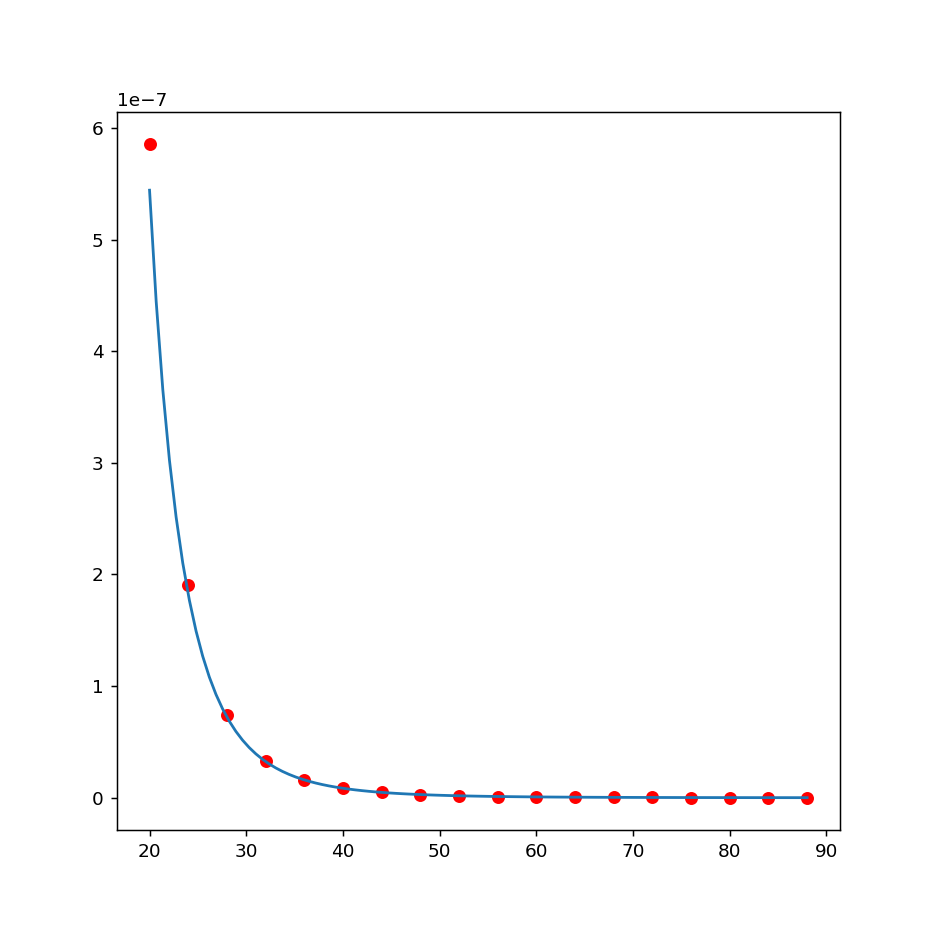

In [16]:
C6 = np.polynomial.polynomial.polyfit(x_arne55**-1, y_arne55, [6], w=x_arne55**6)[-1]
print("C6",C6)
fig = plt.figure(figsize=(7,7))
plt.plot(x_arne55, y_arne55,'ro',figure=fig)
plt.plot(np.linspace(x_arne55[0],x_arne55[-1],num=100), C6*np.linspace(x_arne55[0],x_arne55[-1],num=100)**(-6))

In [3]:
bindingenergy = []
bindinglength = []
for i in range(20,92,4):
    Full_Molec =  psi4.geometry("""
    nocom
    noreorient
    Ar %f 0.0 0.00
    Ne -%f 0.0 0.00
    symmetry c1
    unit bohr
    """ %(i/2.0,i/2.0))

    Monomer_1 =  psi4.geometry("""
    nocom
    noreorient
    @Ar %f 0.0 0.00
    Ne -%f 0.0 0.00
    symmetry c1
    unit bohr
    """ %(i/2.0,i/2.0))

    Monomer_2 =  psi4.geometry("""
    nocom
    noreorient
    Ar %f 0.0 0.00
    @Ne -%f 0.0 0.00
    unit bohr
    symmetry c1
    """ %(i/2.0,i/2.0))

    optionsList = {
        'maxiter': 9000,
        'basis': 'cc-pvdz',
        'reference': 'RKS'
    }
    print("========================%i====================="%i)
    psi4.set_options(optionsList)
    psi4.core.clean
    obj2_e, obj2_wfn = psi4.energy('pbe', molecule=Full_Molec, return_wfn=True)
    psi4.core.clean
    obj2_e1, obj2_wfn1 = psi4.energy('pbe', molecule=Monomer_1, return_wfn=True)
    psi4.core.clean
    obj2_e2, obj2_wfn2 = psi4.energy('pbe', molecule=Monomer_2, return_wfn=True)
    psi4.core.clean

    energy = compute_all96(obj2_wfn1.Da().np, obj2_wfn2.Da().np, obj2_wfn.V_potential(), 5.7)

    # From Hartree to Ry
    energy = energy*2.0
    bindingenergy.append(energy)
    bindinglength.append(i)

x_arne57 = (np.array(bindinglength).astype(float))
y_arne57 = np.array(bindingenergy)

========================20=====================
Electrons Used 7.732860120843707 13.637983452074971
ALL962 3.2370172311705225e-07
========================24=====================
Electrons Used 7.732863319672836 13.637990755653945
ALL962 1.0493782668197661e-07
========================28=====================
Electrons Used 7.732861581623491 13.637988039265423
ALL962 4.081987398131886e-08
========================32=====================
Electrons Used 7.732861380644954 13.637988574935685
ALL962 1.8094222383071068e-08
========================36=====================
Electrons Used 7.732861397594178 13.63798875194627
ALL962 8.850367900626665e-09
========================40=====================
Electrons Used 7.732861402161663 13.637988817917227
ALL962 4.675287310153262e-09
========================44=====================
Electrons Used 7.732861402827908 13.637988844978464
ALL962 2.627417599410471e-09
========================48=====================
Electrons Used 7.732861402263155 13.63798885697

C6 38.30454108637178


<IPython.core.display.Javascript object>


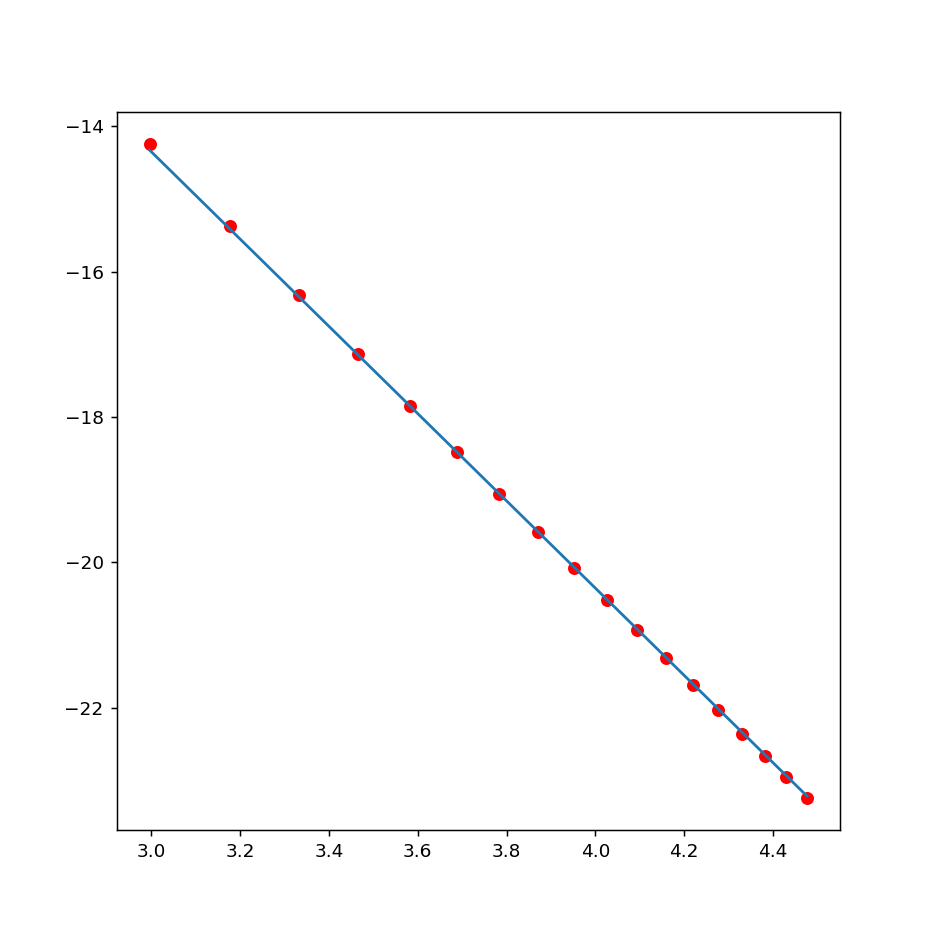

In [8]:
C6 = np.polynomial.polynomial.polyfit(x_arne57**-1, y_arne57, [6], w=x_arne57**6)[-1]
print("C6",C6)
fig = plt.figure(figsize=(7,7))
plt.plot(np.log(x_arne57), np.log(y_arne57),'ro',figure=fig)
plt.plot(np.log(np.linspace(x_arne57[0],x_arne57[-1],num=100)), -6*np.log(np.linspace(x_arne57[0],x_arne57[-1],num=100)) + np.log(C6))

In [50]:
bindingenergy = []
bindinglength = []
for i in range(20,92,4):
    Full_Molec =  psi4.geometry("""
    nocom
    noreorient
    Ar %f 0.0 0.00
    Ne -%f 0.0 0.00
    symmetry c1
    unit bohr
    """ %(i/2.0,i/2.0))

    Monomer_1 =  psi4.geometry("""
    nocom
    noreorient
    @Ar %f 0.0 0.00
    Ne -%f 0.0 0.00
    symmetry c1
    unit bohr
    """ %(i/2.0,i/2.0))

    Monomer_2 =  psi4.geometry("""
    nocom
    noreorient
    Ar %f 0.0 0.00
    @Ne -%f 0.0 0.00
    unit bohr
    symmetry c1
    """ %(i/2.0,i/2.0))

    optionsList = {
        'maxiter': 9000,
        'basis': 'cc-pvdz',
        'reference': 'RKS'
    }
    print("========================%i====================="%i)
    psi4.set_options(optionsList)
    psi4.core.clean
    obj2_e, obj2_wfn = psi4.energy('pbe', molecule=Full_Molec, return_wfn=True)
    psi4.core.clean
    obj2_e1, obj2_wfn1 = psi4.energy('pbe', molecule=Monomer_1, return_wfn=True)
    psi4.core.clean
    obj2_e2, obj2_wfn2 = psi4.energy('pbe', molecule=Monomer_2, return_wfn=True)
    psi4.core.clean

    energy = compute_all96(obj2_wfn1.Da().np, obj2_wfn2.Da().np, obj2_wfn.V_potential(), 6.0)

    # From Hartree to Ry
    energy = energy*2.0
    bindingenergy.append(energy)
    bindinglength.append(i)

x_arne60 = (np.array(bindinglength).astype(float))
y_arne60 = np.array(bindingenergy)

========================20=====================
Electrons Used 7.827732933078714 14.015143161030018
ALL962 3.7586787633029993e-07
========================24=====================
Electrons Used 7.827736637469978 14.015150465526276
ALL962 1.216409665492616e-07
========================28=====================
Electrons Used 7.827734999078013 14.015147761100796
ALL962 4.72703590133451e-08
========================32=====================
Electrons Used 7.827734836948651 14.01514829515902
ALL962 2.0940361972140164e-08
========================36=====================
Electrons Used 7.827734868229413 14.01514847161588
ALL962 1.02381459739372e-08
========================40=====================
Electrons Used 7.827734879160175 14.015148537369411
ALL962 5.4067701341028745e-09
========================44=====================
Electrons Used 7.827734883119171 14.015148564334675
ALL962 3.0378265960115293e-09
========================48=====================
Electrons Used 7.827734884492783 14.0151485762845

C6 44.299299085092606


<IPython.core.display.Javascript object>


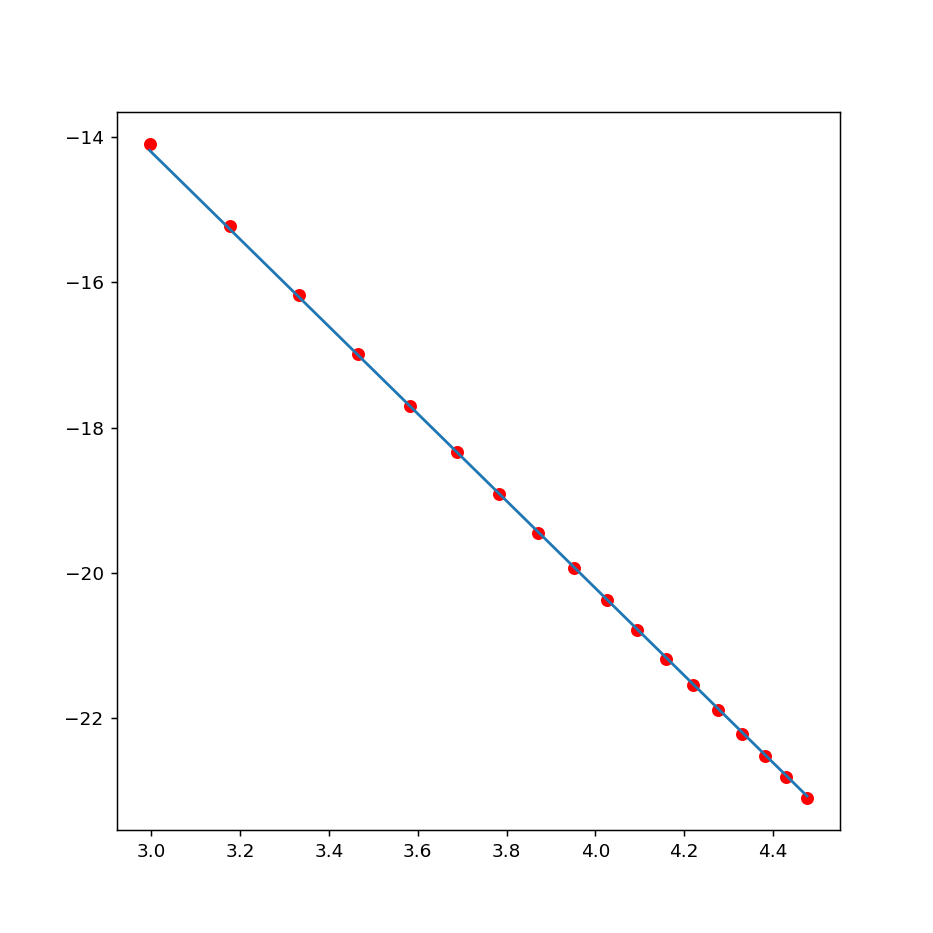

In [76]:
C6 = np.polynomial.polynomial.polyfit(x_arne60**-1, y_arne60, [6], w=x_arne60**6)[-1]
print("C6",C6)
fig = plt.figure(figsize=(7,7))
plt.plot(np.log(x_arne60), np.log(y_arne60),'ro',figure=fig)
plt.plot(np.log(np.linspace(x_arne60[0],x_arne60[-1],num=100)), -6*np.log(np.linspace(x_arne60[0],x_arne60[-1],num=100)) + np.log(C6))

Testing for He2 C6 on ALL96 paper is 3 and experiment is 4. I got 5.13 fo beta=5.8, and 2.9 for beta=5.5.

In [65]:
bindingenergy = []
bindinglength = []
for i in range(20,92,4):
    Full_Molec =  psi4.geometry("""
    nocom
    noreorient
    He %f 0.0 0.00
    He -%f 0.0 0.00
    symmetry c1
    unit bohr
    """ %(i/2.0,i/2.0))

    Monomer_1 =  psi4.geometry("""
    nocom
    noreorient
    @He %f 0.0 0.00
    He -%f 0.0 0.00
    symmetry c1
    unit bohr
    """ %(i/2.0,i/2.0))

    Monomer_2 =  psi4.geometry("""
    nocom
    noreorient
    He %f 0.0 0.00
    @He -%f 0.0 0.00
    unit bohr
    symmetry c1
    """ %(i/2.0,i/2.0))

    optionsList = {
        'maxiter':         9000,
        'basis': 'cc-pvdz',
        'reference': 'RKS'
    }
    print("========================%i====================="%i)
    psi4.set_options(optionsList)
    obj2_e, obj2_wfn = psi4.energy('pbe', molecule=Full_Molec, return_wfn=True)
    psi4.core.clean
    obj2_e1, obj2_wfn1 = psi4.energy('pbe', molecule=Monomer_1, return_wfn=True)
    psi4.core.clean
    obj2_e2, obj2_wfn2 = psi4.energy('pbe', molecule=Monomer_2, return_wfn=True)
    psi4.core.clean

    energy = compute_all96(obj2_wfn1.Da().np, obj2_wfn2.Da().np, obj2_wfn.V_potential(), 6.0)

    # From HHetree to Ry
    energy = energy*2.0
    bindingenergy.append(energy)
    bindinglength.append(i)

x_HeHe60 = (np.array(bindinglength).astype(float))
y_HeHe60 = np.array(bindingenergy)

========================20=====================
Electrons Used 1.881525264507186 1.881525264507183
ALL962 4.020231814871432e-08
========================24=====================
Electrons Used 1.8815253419785705 1.88152534197857
ALL962 1.3257683753641857e-08
========================28=====================
Electrons Used 1.881525340419523 1.8815253404195207
ALL962 5.209337705437066e-09
========================32=====================
Electrons Used 1.8815253349641157 1.8815253349641146
ALL962 2.3240471854803895e-09
========================36=====================
Electrons Used 1.8815253300472998 1.881525330047302
ALL962 1.1417285172245195e-09
========================40=====================
Electrons Used 1.881525326166763 1.8815253261667653
ALL962 6.050021909768767e-10
========================44=====================
Electrons Used 1.8815253231689597 1.8815253231689615
ALL962 3.4077634475449283e-10
========================48=====================
Electrons Used 1.8815253208403722 1.881525320

C6 4.955761715718031


<IPython.core.display.Javascript object>


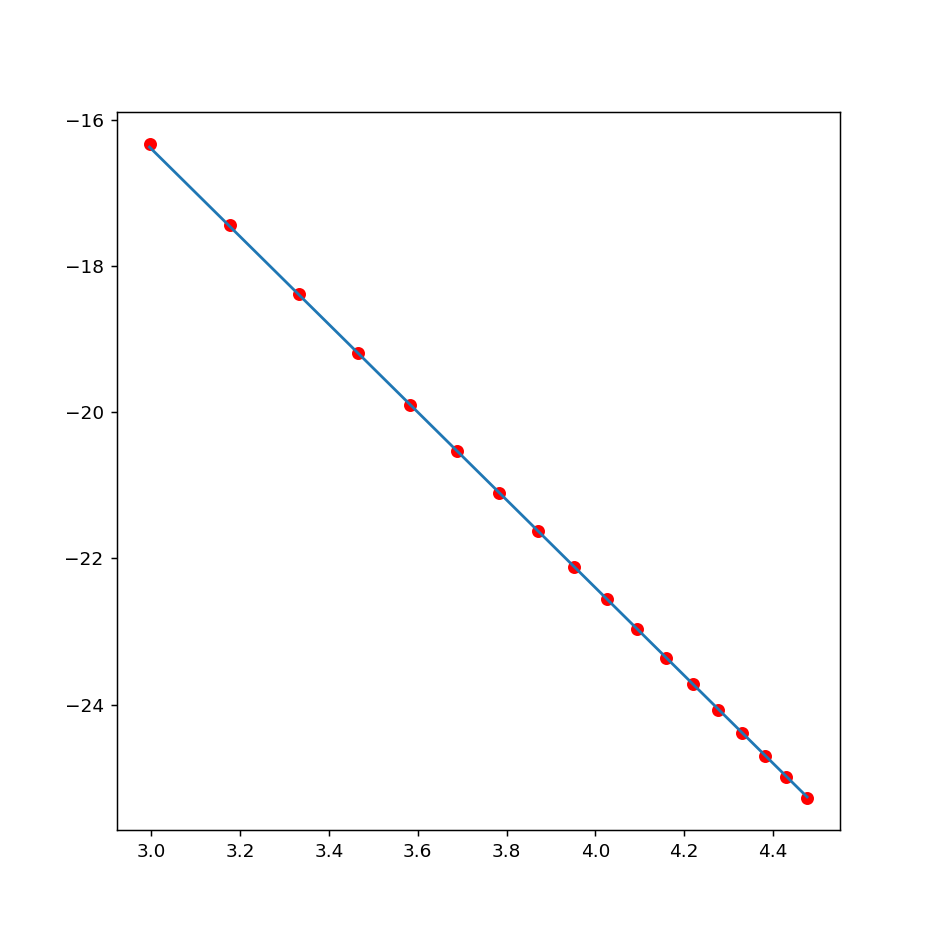

In [77]:
C6 = np.polynomial.polynomial.polyfit(x_HeHe60**-1,y_HeHe60,[6], w=x_HeHe60**6)[-1]
print("C6",C6)
fig = plt.figure(figsize=(7,7))
plt.plot(np.log(x_HeHe60), np.log(y_HeHe60),'ro',figure=fig)
plt.plot(np.log(np.linspace(x_HeHe60[0],x_HeHe60[-1],num=100)), -6*np.log(np.linspace(x_HeHe60[0],x_HeHe60[-1],num=100)) + np.log(C6))

HeKr, experimental is 31, I got 35 from beta=5.8, 25.9 for beta=5.5.

In [64]:
bindingenergy = []
bindinglength = []
for i in range(20,92,4):
    Full_Molec =  psi4.geometry("""
    nocom
    noreorient
    He %f 0.0 0.00
    Kr -%f 0.0 0.00
    symmetry c1
    unit bohr
    """ %(i/2.0,i/2.0))

    Monomer_1 =  psi4.geometry("""
    nocom
    noreorient
    @He %f 0.0 0.00
    Kr -%f 0.0 0.00
    symmetry c1
    unit bohr
    """ %(i/2.0,i/2.0))

    Monomer_2 =  psi4.geometry("""
    nocom
    noreorient
    He %f 0.0 0.00
    @Kr -%f 0.0 0.00
    unit bohr
    symmetry c1
    """ %(i/2.0,i/2.0))

    optionsList = {
        'maxiter':         9000,
        'basis': 'cc-pvdz',
        'reference': 'RKS'
    }
    print("========================%i====================="%i)
    psi4.set_options(optionsList)
    obj2_e, obj2_wfn = psi4.energy('pbe', molecule=Full_Molec, return_wfn=True)
    psi4.core.clean
    obj2_e1, obj2_wfn1 = psi4.energy('pbe', molecule=Monomer_1, return_wfn=True)
    psi4.core.clean
    obj2_e2, obj2_wfn2 = psi4.energy('pbe', molecule=Monomer_2, return_wfn=True)
    psi4.core.clean

    energy = compute_all96(obj2_wfn1.Da().np, obj2_wfn2.Da().np, obj2_wfn.V_potential(), 60)

    # From HHetree to Ry
    energy = energy*2.0
    bindingenergy.append(energy)
    bindinglength.append(i)
    
x_HeKr60 = (np.array(bindinglength).astype(float))
y_HeKr60 = np.array(bindingenergy)

========================20=====================
Electrons Used 35.99999568498426 1.999988377023745
ALL962 1.625155603884377e-06
========================24=====================
Electrons Used 35.99997756661846 1.999988586589887
ALL962 4.872017230285758e-07
========================28=====================
Electrons Used 35.99998140518292 1.9999886972289227
ALL962 1.8164348991583302e-07
========================32=====================
Electrons Used 35.999982478813685 1.999989921914364
ALL962 7.845695263870538e-08
========================36=====================
Electrons Used 35.999982828998334 1.9999891125954643
ALL962 3.7724053243862884e-08
========================40=====================
Electrons Used 35.99998295816799 1.9999891635509413
ALL962 1.9691694249243372e-08
========================44=====================
Electrons Used 35.99998301076755 1.9999891852051792
ALL962 1.0970794633275794e-08
========================48=====================
Electrons Used 35.99998303399854 1.99998919511

/home/yuming/anaconda3/envs/work/lib/python3.7/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in power
/home/yuming/anaconda3/envs/work/lib/python3.7/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in less_equal


Electrons Used 35.999983056388295 1.9999892051892916
ALL962 5.499844578080822e-10
========================76=====================
Electrons Used 35.999983056711166 1.9999892053481616
ALL962 3.967037461303328e-10
========================80=====================
Electrons Used 35.99998305691219 1.999989205448273
ALL962 2.910434094137379e-10
========================84=====================
Electrons Used 35.99998305704034 1.9999892055127881
ALL962 2.168160672713293e-10
========================88=====================
Electrons Used 35.999983057123835 1.9999892055552182
ALL962 1.6377167830568542e-10


C6 162.1067100489349


<IPython.core.display.Javascript object>


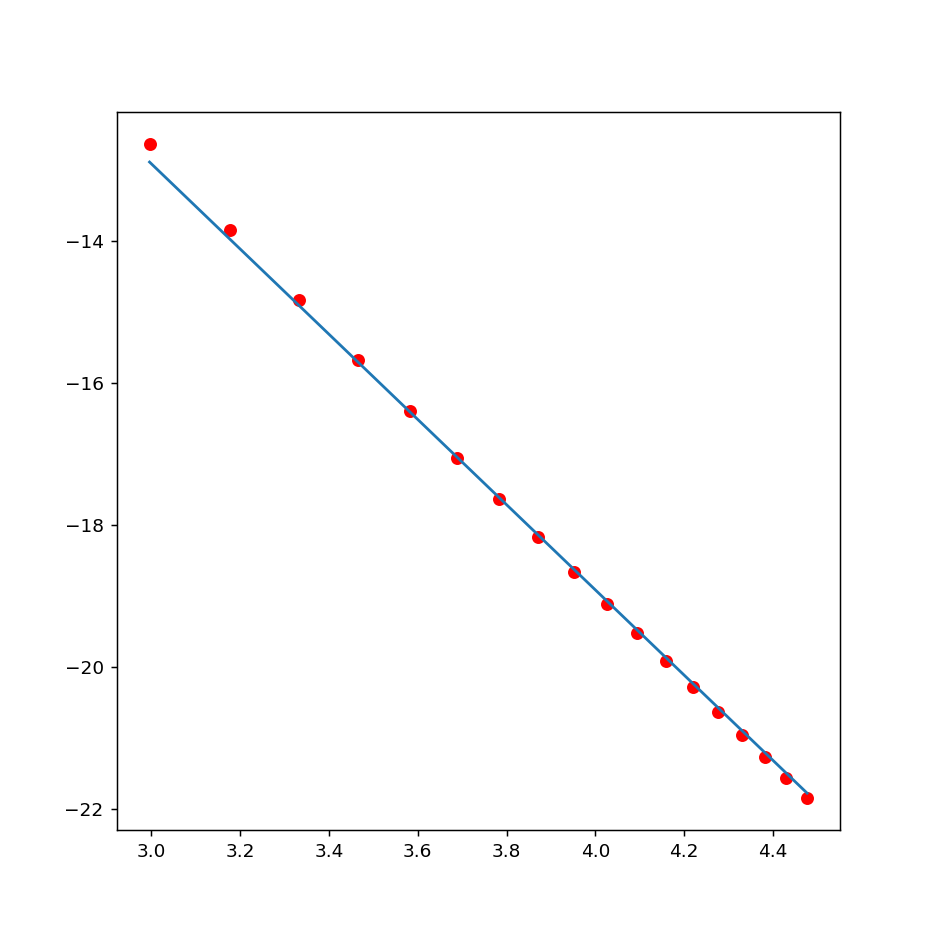

In [80]:
C6 = np.polynomial.polynomial.polyfit(x_HeKr60**-1,y_HeKr60,[6], w=x_HeKr60**6)[-1]
print("C6",C6)
fig = plt.figure(figsize=(7,7))
plt.plot(np.log(x_HeKr60), np.log(y_HeKr60),'ro',figure=fig)
plt.plot(np.log(np.linspace(x_HeKr60[0],x_HeKr60[-1],num=100)), -6*np.log(np.linspace(x_HeKr60[0],x_HeKr60[-1],num=100)) + np.log(C6))

ArKr experimental 187, I got 189.07768115713637 for beta=5.8.

In [3]:
bindingenergy = []
bindinglength = []
for i in range(20,92,4):
    Full_Molec =  psi4.geometry("""
    nocom
    noreorient
    Ar %f 0.0 0.00
    Kr -%f 0.0 0.00
    symmetry c1
    unit bohr
    """ %(i/2.0,i/2.0))

    Monomer_1 =  psi4.geometry("""
    nocom
    noreorient
    @Ar %f 0.0 0.00
    Kr -%f 0.0 0.00
    symmetry c1
    unit bohr
    """ %(i/2.0,i/2.0))

    Monomer_2 =  psi4.geometry("""
    nocom
    noreorient
    Ar %f 0.0 0.00
    @Kr -%f 0.0 0.00
    unit bohr
    symmetry c1
    """ %(i/2.0,i/2.0))

    optionsList = {
        'maxiter':         9000,
        'basis': 'cc-pvdz',
        'reference': 'RKS'
    }
    print("========================%i====================="%i)
    psi4.set_options(optionsList)
    obj2_e, obj2_wfn = psi4.energy('pbe', molecule=Full_Molec, return_wfn=True)
    psi4.core.clean
    obj2_e1, obj2_wfn1 = psi4.energy('pbe', molecule=Monomer_1, return_wfn=True)
    psi4.core.clean
    obj2_e2, obj2_wfn2 = psi4.energy('pbe', molecule=Monomer_2, return_wfn=True)
    psi4.core.clean

    energy = compute_all96(obj2_wfn1.Da().np, obj2_wfn2.Da().np, obj2_wfn.V_potential(), 5.5)

    # From HArtree to Ry
    energy = energy*2.0
    bindingenergy.append(energy)
    bindinglength.append(i)
    
x_ArKr = (np.array(bindinglength).astype(float))
y_ArKr = np.array(bindingenergy)

========================20=====================
Electrons Used 29.128413709688832 13.56506809632523
ALL962 1.3186651459259134e-06
========================24=====================
Electrons Used 29.128396164146377 13.565069582602652
ALL962 4.188807086328197e-07
========================28=====================
Electrons Used 29.128386523386705 13.56506651008268
ALL962 1.610538385211922e-07
========================32=====================
Electrons Used 29.12838875940207 13.5650720391144
ALL962 7.086950614111693e-08
========================36=====================
Electrons Used 29.128389545583143 13.565068337151486
ALL962 3.449362517466925e-08
========================40=====================
Electrons Used 29.128389830319588 13.565068497360667
ALL962 1.8158294191760087e-08
========================44=====================
Electrons Used 29.12838994724064 13.565068563804658
ALL962 1.0178614596328798e-08
========================48=====================
Electrons Used 29.128389998712873 13.56506859

/home/yuming/anaconda3/envs/work/lib/python3.7/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in power
/home/yuming/anaconda3/envs/work/lib/python3.7/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in less_equal


Electrons Used 29.128390044383856 13.565068622759759
ALL962 2.0529061141446398e-10
========================88=====================
Electrons Used 29.128390044181344 13.565068622809697
ALL962 1.5516854260710646e-10


R6 fit C6 167.6463092057605
log-log fit 209.06498195810494 6.087241763589274


<IPython.core.display.Javascript object>


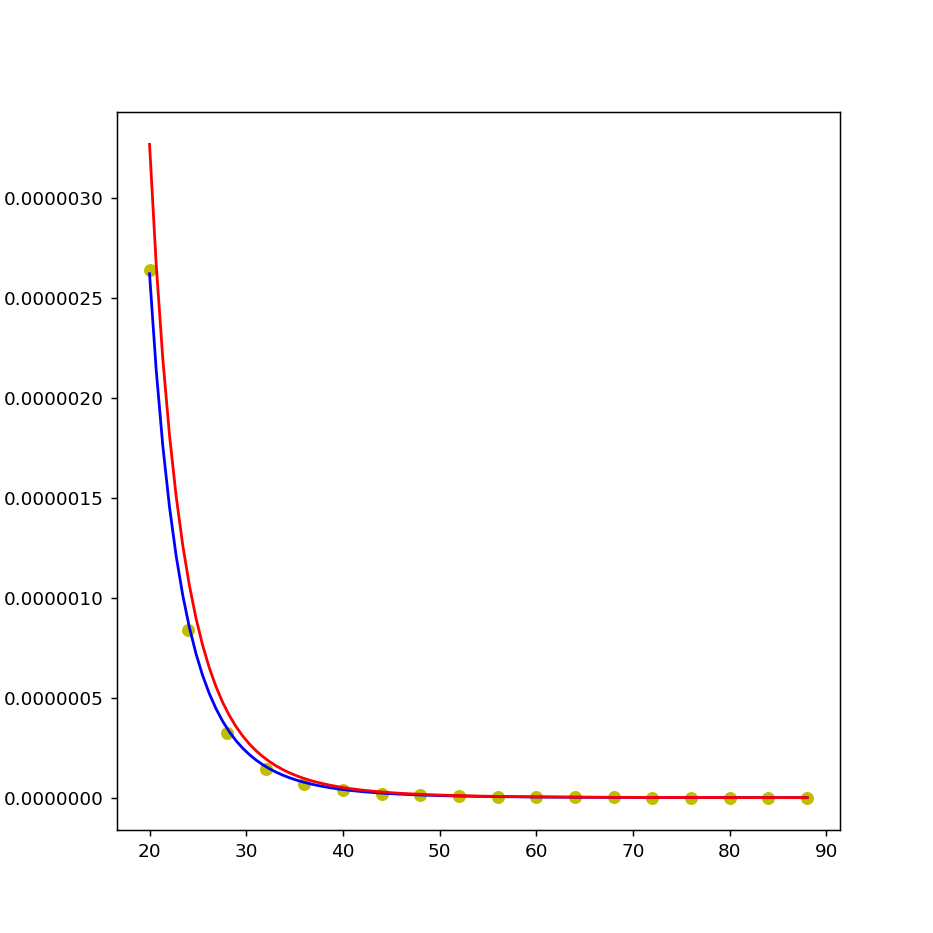

In [25]:
C6 = np.polynomial.polynomial.polyfit(x_ArKr**-1,y_ArKr,[6])[-1]
print("R6 fit C6",C6)
C6exp, expo = np.polynomial.polynomial.polyfit(np.log(x_ArKr**-1),np.log(y_ArKr), 1)
print("log-log fit", np.exp(C6exp), expo)
fig = plt.figure(figsize=(7,7))
plt.plot(x_ArKr, y_ArKr,'yo',figure=fig)
plt.plot(np.linspace(x_ArKr[0],x_ArKr[-1],num=100), C6*np.linspace(x_ArKr[0],x_ArKr[-1],num=100)**(-6), 'b')
plt.plot(np.linspace(x_ArKr[0],x_ArKr[-1],num=100), np.exp(C6exp)*np.linspace(x_ArKr[0],x_ArKr[-1],num=100)**(-6), 'r')

209.06498195810494 6.087241763589274


<IPython.core.display.Javascript object>


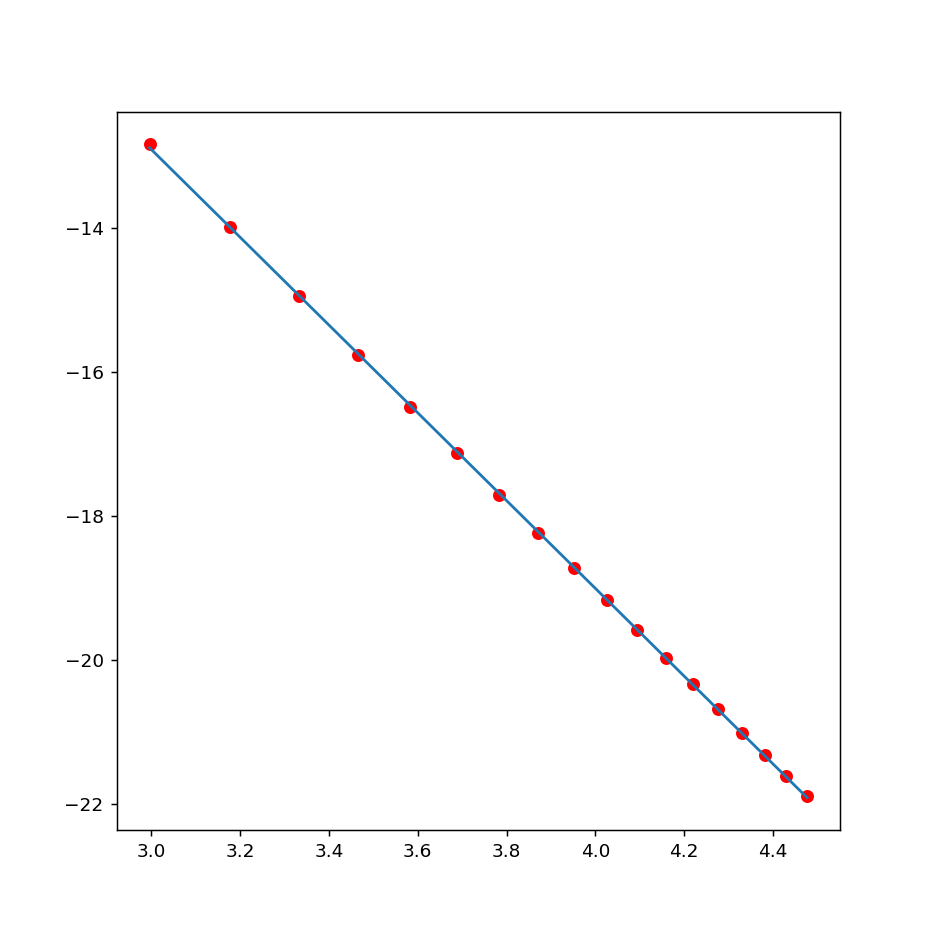

In [22]:
blog, C6log = np.polynomial.polynomial.polyfit(np.log(x_ArKr**-1),np.log(y_ArKr), 1)
print(np.exp(b), C6)
fig = plt.figure(figsize=(7,7))
plt.plot(np.log(x_ArKr), np.log(y_ArKr),'ro',figure=fig)
plt.plot(np.log(np.linspace(x_ArKr[0],x_ArKr[-1],num=100)), C6*np.log(np.linspace(x_ArKr[0],x_ArKr[-1],num=100)**(-1)) + b)

KrKr experimental 266, I got 243 for beta=5.5.

In [4]:
bindingenergy = []
bindinglength = []
for i in range(20,92,4):
    Full_Molec =  psi4.geometry("""
    nocom
    noreorient
    Kr %f 0.0 0.00
    Kr -%f 0.0 0.00
    symmetry c1
    unit bohr
    """ %(i/2.0,i/2.0))

    Monomer_1 =  psi4.geometry("""
    nocom
    noreorient
    @Kr %f 0.0 0.00
    Kr -%f 0.0 0.00
    symmetry c1
    unit bohr
    """ %(i/2.0,i/2.0))

    Monomer_2 =  psi4.geometry("""
    nocom
    noreorient
    Kr %f 0.0 0.00
    @Kr -%f 0.0 0.00
    unit bohr
    symmetry c1
    """ %(i/2.0,i/2.0))

    optionsList = {
        'maxiter':         9000,
        'basis': 'cc-pvdz',
        'reference': 'RKS'
    }
    print("========================%i====================="%i)
    psi4.set_options(optionsList)
    obj2_e, obj2_wfn = psi4.energy('pbe', molecule=Full_Molec, return_wfn=True)
    psi4.core.clean
    obj2_e1, obj2_wfn1 = psi4.energy('pbe', molecule=Monomer_1, return_wfn=True)
    psi4.core.clean
    obj2_e2, obj2_wfn2 = psi4.energy('pbe', molecule=Monomer_2, return_wfn=True)
    psi4.core.clean

    energy = compute_all96(obj2_wfn1.Da().np, obj2_wfn2.Da().np, obj2_wfn.V_potential(), 5.5)

    # From HKrtree to Ry
    energy = energy*2.0
    bindingenergy.append(energy)
    bindinglength.append(i)
    
x_KrKr = (np.array(bindinglength).astype(float))
y_KrKr = np.array(bindingenergy)

========================20=====================
Electrons Used 29.1283626329396 29.12836263293925
ALL962 1.9188074676645527e-06
========================24=====================
Electrons Used 29.12838455010628 29.12838455010602
ALL962 6.046201532325094e-07
========================28=====================
Electrons Used 29.128385144669046 29.12838514466887
ALL962 2.3139941362805866e-07
========================32=====================
Electrons Used 29.1283933272666 29.128393327266174
ALL962 1.0153068961903916e-07
========================36=====================
Electrons Used 29.12838937410289 29.128389374102838
ALL962 4.932180372743639e-08
========================40=====================
Electrons Used 29.128389754369756 29.128389754369852
ALL962 2.5929070400391114e-08
========================44=====================
Electrons Used 29.128389911438088 29.128389911438124
ALL962 1.4520146876629275e-08
========================48=====================
Electrons Used 29.128389981051946 29.128389981

/home/yuming/anaconda3/envs/work/lib/python3.7/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in power
/home/yuming/anaconda3/envs/work/lib/python3.7/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in less_equal


Electrons Used 29.128390044729116 29.128390044729304
ALL962 2.9187917242503744e-10
========================88=====================
Electrons Used 29.12839004455047 29.12839004455085
ALL962 2.2059211805033364e-10


AttributeError: module 'numpy' has no attribute 'Krray'

C6 243.70015450138627


<IPython.core.display.Javascript object>


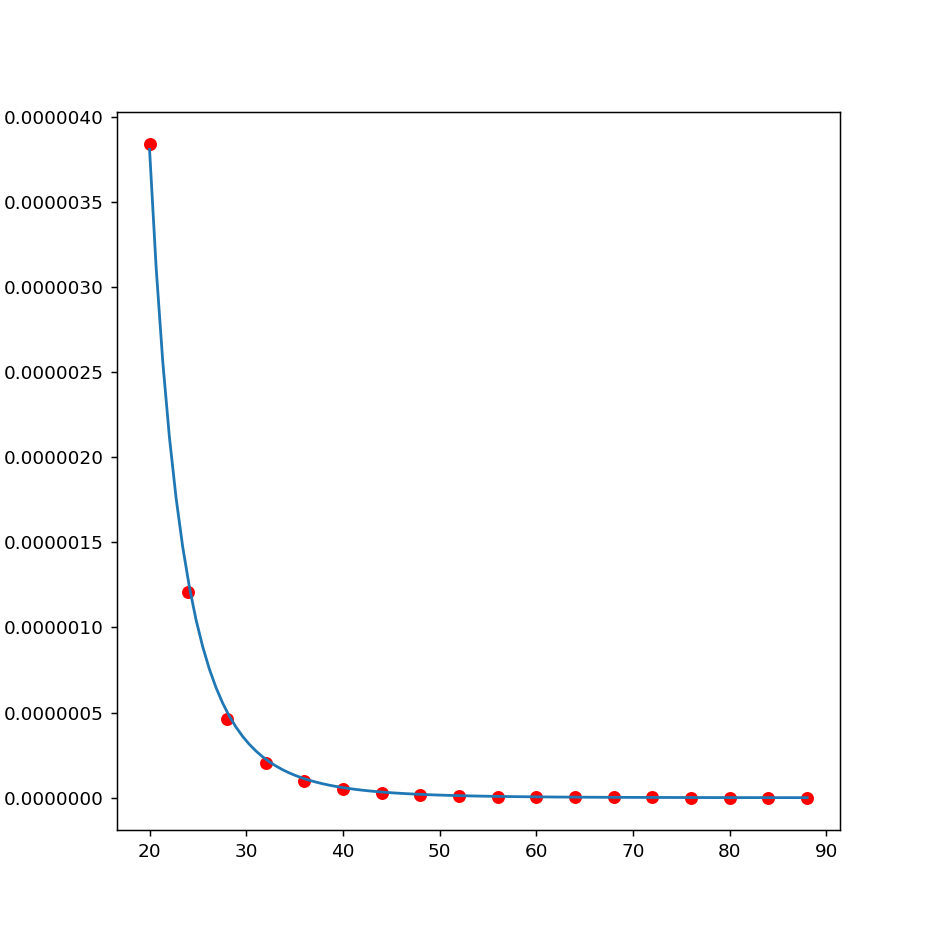

In [6]:
C6 = np.polynomial.polynomial.polyfit(x_KrKr**-1,y_KrKr,[6])[-1]
print("C6",C6)
fig = plt.figure(figsize=(7,7))
plt.plot(x_KrKr, y_KrKr,'ro',figure=fig)
plt.plot(np.linspace(x_KrKr[0],x_KrKr[-1],num=100), C6*np.linspace(x_KrKr[0],x_KrKr[-1],num=100)**(-6))

In [4]:
bindingenergy = []
bindinglength = []
for i in range(20,92,4):
    Full_Molec =  psi4.geometry("""
    nocom
    noreorient
    Xe %f 0.0 0.00
    Kr -%f 0.0 0.00
    symmetry c1
    unit bohr
    """ %(i/2.0,i/2.0))

    Monomer_1 =  psi4.geometry("""
    nocom
    noreorient
    @Xe %f 0.0 0.00
    Kr -%f 0.0 0.00
    symmetry c1
    unit bohr
    """ %(i/2.0,i/2.0))

    Monomer_2 =  psi4.geometry("""
    nocom
    noreorient
    Xe %f 0.0 0.00
    @Kr -%f 0.0 0.00
    unit bohr
    symmetry c1
    """ %(i/2.0,i/2.0))

    optionsList = {
        'maxiter':         9000,
        'basis': 'def2-qzvpp-ri',
        'reference': 'RKS'
    }
    print("========================%i====================="%i)
    psi4.set_options(optionsList)
    obj2_e, obj2_wfn = psi4.energy('pbe', molecule=Full_Molec, return_wfn=True)
    psi4.core.clean
    obj2_e1, obj2_wfn1 = psi4.energy('pbe', molecule=Monomer_1, return_wfn=True)
    psi4.core.clean
    obj2_e2, obj2_wfn2 = psi4.energy('pbe', molecule=Monomer_2, return_wfn=True)
    psi4.core.clean

    energy = compute_all96(obj2_wfn1.Da().np, obj2_wfn2.Da().np, obj2_wfn.V_potential(), 5.5)

    # From HXetree to Ry
    energy = energy*2.0
    bindingenergy.append(energy)
    bindinglength.append(i)
    
x_XeKr = (np.array(bindinglength).astype(float))
y_XeKr = np.array(bindingenergy)

========================20=====================
Electrons Used 29.12841370968884 14.015139986431686
ALL962 1.487870995960087e-06
========================24=====================
Electrons Used 29.12839616414636 14.015147384151897
ALL962 4.710175686230887e-07
========================28=====================
Electrons Used 29.128389797636732 14.015145747950395
ALL962 1.8075078238383386e-07
========================32=====================
Electrons Used 29.12838875940206 14.015151783827381
ALL962 7.944029451736174e-08
========================36=====================
Electrons Used 29.128389545583154 14.015148183169902
ALL962 3.863397817692243e-08
========================40=====================
Electrons Used 29.12838983031959 14.015148408591598
ALL962 2.032632690453826e-08
========================44=====================
Electrons Used 29.128389947240642 14.015148502612593
ALL962 1.1389174909195596e-08
========================48=====================
Electrons Used 29.12838999871287 14.01514854

/home/yuming/anaconda3/envs/work/lib/python3.7/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in power
/home/yuming/anaconda3/envs/work/lib/python3.7/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in less_equal


Electrons Used 29.128390044383845 14.015148587665175
ALL962 2.2938465739422059e-10
========================88=====================
Electrons Used 29.128390044181337 14.015148587792588
ALL962 1.733719792303066e-10


C6 243.70015450138627


<IPython.core.display.Javascript object>


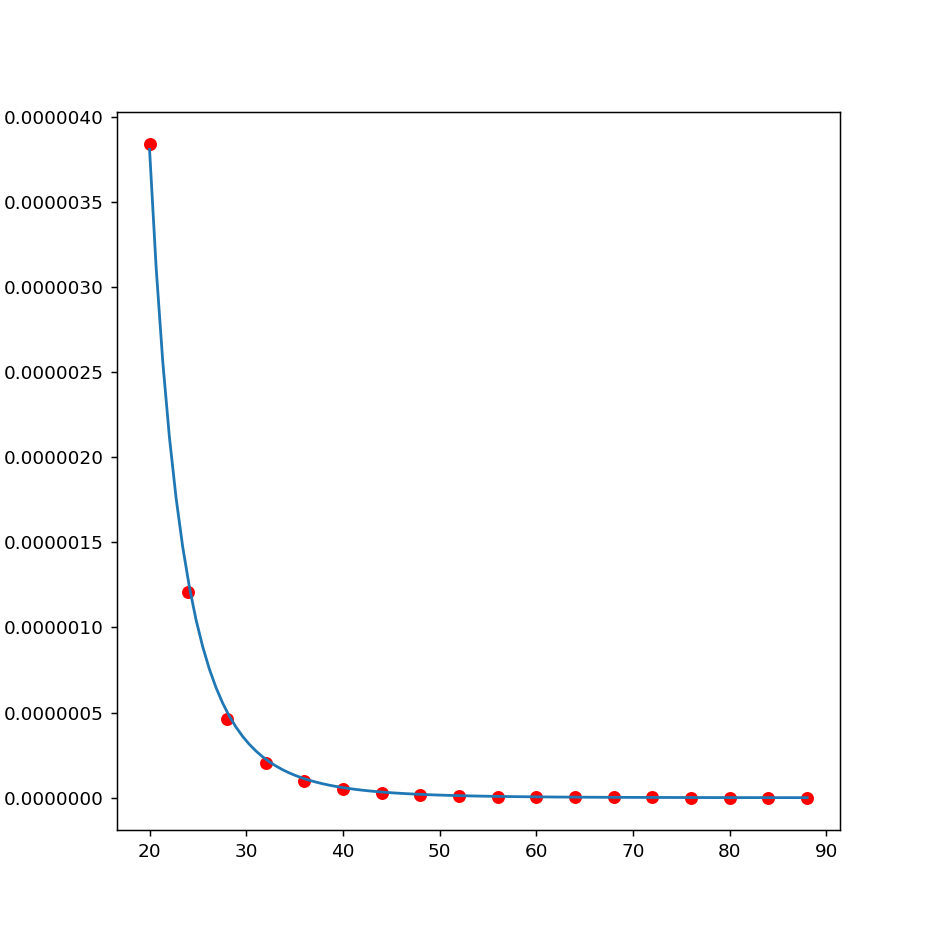

In [6]:
C6 = np.polynomial.polynomial.polyfit(x_XeKr**-1,y_XeKr,[6])[-1]
print("C6",C6)
fig = plt.figure(figsize=(7,7))
plt.plot(x_XeKr, y_XeKr,'ro',figure=fig)
plt.plot(np.linspace(x_XeKr[0],x_XeKr[-1],num=100), C6*np.linspace(x_XeKr[0],x_XeKr[-1],num=100)**(-6))

vp based on E_all with local-Q approximation.

In [28]:
def vp_all96(D1,D2,Vpot,beta=6):
    """
    Return vp on grid and vp_fock on the basis.
    """
    
    w = Vpot.get_np_xyzw()[-1]
    
    C = -6.0/4.0/(4*np.pi)**1.5
    
    vp = np.zeros_like(w)
    vp_fock = np.zeros_like(D1)
    
    del w
    
    points_func = Vpot.properties()[0]
    superfunc = Vpot.functional()
    
    w1_old = 0
    n1 = 0.0
    
    # First loop over the outer set of blocks
    for l_block in range(Vpot.nblocks()):
#     for l_block in range(70,Vpot.nblocks()):
        # Obtain general grid information
        l_grid = Vpot.get_block(l_block)
        l_w = np.array(l_grid.w())
        l_x = np.array(l_grid.x())
        l_y = np.array(l_grid.y())
        l_z = np.array(l_grid.z())
        l_npoints = l_w.shape[0]
        
        points_func.compute_points(l_grid)
        l_lpos = np.array(l_grid.functions_local_to_global())

        # Compute phi!
        l_phi = np.array(points_func.basis_values()["PHI"])[:l_npoints, :l_lpos.shape[0]]
        l_phi_x = np.array(points_func.basis_values()["PHI_X"])[:l_npoints, :l_lpos.shape[0]]
        l_phi_y = np.array(points_func.basis_values()["PHI_Y"])[:l_npoints, :l_lpos.shape[0]]
        l_phi_z = np.array(points_func.basis_values()["PHI_Z"])[:l_npoints, :l_lpos.shape[0]]
        # Build a local slice of D
        lD1 = D1[(l_lpos[:, None], l_lpos)]
        
        # Copmute block-rho and block-gamma
        rho1 = 2.0 * np.einsum('pm,mn,pn->p', l_phi, lD1, l_phi, optimize=True)
        
        total_rho1 = 2.0 * np.einsum('pm,mn,pn->p', l_phi, lD1 + D2[(l_lpos[:, None], l_lpos)], l_phi, optimize=True)
        
        # 2.0 for Px D P + P D Px, 2.0 for non-spin Density
        rho_x1 = 4.0 * np.einsum('pm,mn,pn->p', l_phi, lD1, l_phi_x, optimize=True)
        rho_y1 = 4.0 * np.einsum('pm,mn,pn->p', l_phi, lD1, l_phi_y, optimize=True)
        rho_z1 = 4.0 * np.einsum('pm,mn,pn->p', l_phi, lD1, l_phi_z, optimize=True)
        gamma1 = rho_x1 ** 2 + rho_y1 ** 2 + rho_z1 ** 2
        
        # The integral cutoff.
        l_local_w_homo = gamma1**0.5 <= 2 * beta * ((9 * np.pi)**(-1.0/6.0))*(rho1**(7.0/6.0))
        l_local_w_rho = rho1 > 1e-34
        l_local_w = l_local_w_homo*l_local_w_rho

        if not np.any(l_local_w):
            w1_old += l_npoints
            continue
        
        n2 = 0.0
        w2_old = 0
        # Loop over the inner set of blocks
        for r_block in range(Vpot.nblocks()):
            
            r_grid = Vpot.get_block(r_block)
            r_w = np.array(r_grid.w())
            r_x = np.array(r_grid.x())
            r_y = np.array(r_grid.y())
            r_z = np.array(r_grid.z())
            r_npoints = r_w.shape[0]
            
            points_func.compute_points(r_grid)
            r_lpos = np.array(r_grid.functions_local_to_global())
            
            # Compute phi!
            r_phi = np.array(points_func.basis_values()["PHI"])[:r_npoints, :r_lpos.shape[0]]
            r_phi_x = np.array(points_func.basis_values()["PHI_X"])[:r_npoints, :r_lpos.shape[0]]
            r_phi_y = np.array(points_func.basis_values()["PHI_Y"])[:r_npoints, :r_lpos.shape[0]]
            r_phi_z = np.array(points_func.basis_values()["PHI_Z"])[:r_npoints, :r_lpos.shape[0]]
            
            # Build a local slice of D
            lD2 = D2[(r_lpos[:, None], r_lpos)]
            
            total_rho2 = 2.0 * np.einsum('pm,mn,pn->p', r_phi, D1[(r_lpos[:, None], r_lpos)] + lD2, r_phi, optimize=True)

            # Copmute block-rho and block-gamma
            rho2 = 2.0 * np.einsum('pm,mn,pn->p', r_phi, lD2, r_phi, optimize=True)
            # 2.0 for Px D P + P D Px, 2.0 for non-spin Density
            rho_x2 = 4.0 * np.einsum('pm,mn,pn->p', r_phi, lD2, r_phi_x, optimize=True)
            rho_y2 = 4.0 * np.einsum('pm,mn,pn->p', r_phi, lD2, r_phi_y, optimize=True)
            rho_z2 = 4.0 * np.einsum('pm,mn,pn->p', r_phi, lD2, r_phi_z, optimize=True)
            gamma2 = rho_x2 ** 2 + rho_y2 ** 2 + rho_z2 ** 2
            
            # The integrate cutoff.
            r_local_w_homo = gamma2**0.5 <= 2 * beta * ((9 * np.pi)**(-1.0/6.0)) * (rho2**(7.0/6.0))
            r_local_w_rho = rho2 > 1e-34
            r_local_w = r_local_w_homo * r_local_w_rho
#           r_local_w = r_local_w_homo
            
            if not np.any(r_local_w):
                w2_old += r_npoints
                continue
    
            # Build the distnace matrix
            R2  = (l_x[:, None] - r_x) ** 2
            R2 += (l_y[:, None] - r_y) ** 2
            R2 += (l_z[:, None] - r_z) ** 2
#             R2 += 1e-34
            R6inv = R2**-3
            np.fill_diagonal(R6inv, 0.0)
            
            # Add vp for fragment 1
            vp[w1_old:w1_old+l_npoints] += np.sum(rho2
                                                / (np.sqrt(rho1[:, None]) + np.sqrt(rho2) + 1e-34)**2
                                                * R6inv * r_local_w * r_w, axis=1
                                               ) * np.sqrt(rho1) / (total_rho1 + 1e-68) * 0.5 * l_local_w
            # Add vp for fragment 2
            vp[w2_old:w2_old+r_npoints] += np.sum(rho1[:, None]
                                                / (np.sqrt(rho1[:, None]) + np.sqrt(rho2) + 1e-34)**2
                                                * R6inv * l_local_w[:, None] * l_w[:, None], axis=0
                                               ) * np.sqrt(rho2) / (total_rho2 + 1e-68) * 0.5 * r_local_w
            # Add vp_fock for fragment 2
            vp_fock[(r_lpos[:, None], r_lpos)] += np.einsum("p,p,pa,pb->ab", r_w, vp[w2_old:w2_old+r_npoints], r_phi, r_phi, optimize=True)
            n2 += np.sum(rho2 * r_local_w * r_w)
            w2_old += r_npoints
        
#       Add vp_fock for fragment 1
        vp_fock[(l_lpos[:, None], l_lpos)] += np.einsum("p,p,pa,pb->ab", l_w, vp[w1_old:w1_old+l_npoints], l_phi, l_phi, optimize=True)
        n1 += np.sum(rho1 * l_local_w * l_w)
        w1_old += l_npoints
        
    vp *= C
    vp_fock *= C
    if np.all(np.abs(vp) < 1e3): 
        print("Unphysical vp %f" % np.linalg.norm(vp))
    print("Electrons Used", n1, n2)
    return vp, vp_fock

Unphysical vp 0.000002
Electrons Used 1.881525264507186 1.881525264507183


<IPython.core.display.Javascript object>


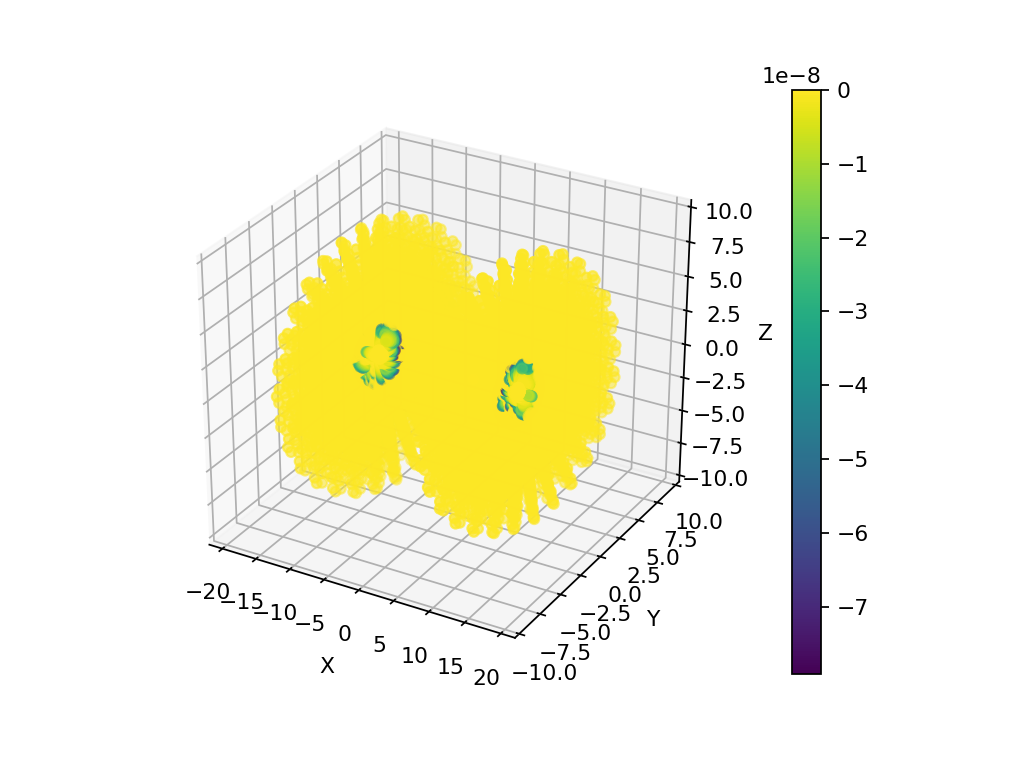

Text(0.5, 0, 'Z')

In [32]:
i = 20

Full_Molec =  psi4.geometry("""
nocom
noreorient
He %f 0.0 0.00
He -%f 0.0 0.00
symmetry c1
unit bohr
""" %(i/2.0,i/2.0))

Monomer_1 =  psi4.geometry("""
nocom
noreorient
@He %f 0.0 0.00
He -%f 0.0 0.00
symmetry c1
unit bohr
""" %(i/2.0,i/2.0))

Monomer_2 =  psi4.geometry("""
nocom
noreorient
He %f 0.0 0.00
@He -%f 0.0 0.00
unit bohr
symmetry c1
""" %(i/2.0,i/2.0))

optionsList = {
    'maxiter': 9000,
    'basis':  'cc-pvdz',
    'reference': 'RKS'
}
psi4.set_options(optionsList)

psi4.set_options(optionsList)
obj2_e, obj2_wfn = psi4.energy('pbe', molecule=Full_Molec, return_wfn=True)
psi4.core.clean
obj2_e1, obj2_wfn1 = psi4.energy('pbe', molecule=Monomer_1, return_wfn=True)
psi4.core.clean
obj2_e2, obj2_wfn2 = psi4.energy('pbe', molecule=Monomer_2, return_wfn=True)
psi4.core.clean

vp, vp_fock = vp_all96(obj2_wfn1.Da().np, obj2_wfn2.Da().np, obj2_wfn.V_potential())
x,y,z,_ = obj2_wfn.V_potential().get_np_xyzw()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(x, y, z, c=vp)
plt.colorbar(p)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

In [33]:
print(vp_fock)

[[-1.33380996e-07 -2.37974064e-07  1.34662619e-10  4.29805014e-08
   1.18702211e-10 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  -0.00000000e+00 -0.00000000e+00]
 [-2.37974064e-07 -8.86281703e-07  3.72569518e-10  1.21181852e-07
   3.05348010e-10 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  -0.00000000e+00 -0.00000000e+00]
 [ 1.34662619e-10  3.72569518e-10 -3.83240915e-07 -4.77499126e-11
  -1.63598732e-11 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  -0.00000000e+00 -0.00000000e+00]
 [ 4.29805014e-08  1.21181852e-07 -4.77499126e-11 -3.98707228e-07
  -7.68091766e-11 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  -0.00000000e+00 -0.00000000e+00]
 [ 1.18702211e-10  3.05348010e-10 -1.63598732e-11 -7.68091766e-11
  -3.84001429e-07 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  -0.00000000e+00 -0.00000000e+00]
 [-0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  -0.00000000e+00 -1.56653017e-09 -2.78609776e-09 -2.57517597e-14
  -5.04970585e-10  4.38263300e-13

In [34]:
vp_fock - vp_fock.T

array([[ 0.00000000e+00,  0.00000000e+00, -2.32644547e-25,
         0.00000000e+00, -1.03397577e-25,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00, -6.20385459e-25,
        -2.64697796e-23,  8.78879401e-25,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 2.32644547e-25,  6.20385459e-25,  0.00000000e+00,
         3.29579775e-25, -8.40105310e-26,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  2.64697796e-23, -3.29579775e-25,
         0.00000000e+00, -9.82276977e-25,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 1.03397577e-25, -8.78879401e-25,  8.40105310e-26,
         9.82276977e-25,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.